# <b><span style='color:#F1A424'>AutoML - Binary Classification - Titanic Survival Prediction </span> </b>

### Disclaimer
Please note, the Vantage Functions via SQLAlchemy feature is a preview/beta code release with limited functionality (the “Code”). As such, you acknowledge that the Code is experimental in nature and that the Code is provided “AS IS” and may not be functional on any machine or in any environment. TERADATA DISCLAIMS ALL WARRANTIES RELATING TO THE CODE, EXPRESS OR IMPLIED, INCLUDING, BUT NOT LIMITED TO, ANY WARRANTIES AGAINST INFRINGEMENT OF THIRD-PARTY RIGHTS, MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE.

TERADATA SHALL NOT BE RESPONSIBLE OR LIABLE WITH RESPECT TO ANY SUBJECT MATTER OF THE CODE UNDER ANY CONTRACT, NEGLIGENCE, STRICT LIABILITY OR OTHER THEORY 
    (A) FOR LOSS OR INACCURACY OF DATA OR COST OF PROCUREMENT OF SUBSTITUTE GOODS, SERVICES OR TECHNOLOGY, OR 
    (B) FOR ANY INDIRECT, INCIDENTAL OR CONSEQUENTIAL DAMAGES INCLUDING, BUT NOT LIMITED TO LOSS OF REVENUES AND LOSS OF PROFITS. TERADATA SHALL NOT BE RESPONSIBLE FOR ANY MATTER BEYOND ITS REASONABLE CONTROL.

Notwithstanding anything to the contrary: 
    (a) Teradata will have no obligation of any kind with respect to any Code-related comments, suggestions, design changes or improvements that you elect to provide to Teradata in either verbal or written form (collectively, “Feedback”), and 
    (b) Teradata and its affiliates are hereby free to use any ideas, concepts, know-how or techniques, in whole or in part, contained in Feedback: 
        (i) for any purpose whatsoever, including developing, manufacturing, and/or marketing products and/or services incorporating Feedback in whole or in part, and 
        (ii) without any restrictions or limitations, including requiring the payment of any license fees, royalties, or other consideration. 

## <b> Problem overview:</b>
    


The Titanic dataset is a well-known dataset in the field of machine learning and data science. It contains information about passengers aboard the RMS Titanic, including whether they survived or not. The dataset is often used for predictive modeling and classification tasks. Here are some key details about the Titanic dataset:

**Features**:

- `PassengerId`: Unique identifier for each passenger.
- `Pclass`: Ticket class (1st, 2nd, or 3rd).
- `Name`: Passenger's name.
- `Sex`: Passenger's gender (male or female).
- `Age`: Passenger's age.
- `SibSp`: Number of siblings or spouses aboard.
- `Parch`: Number of parents or children aboard.
- `Ticket`: Ticket number.
- `Fare`: Fare paid for the ticket.
- `Cabin`: Cabin number.
- `Embarked`: Port of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton).

**Target Variable**:

- `Survived`: Binary variable indicating whether the passenger survived (1) or not (0).
        
**Objective**:

The main objective is typically to build a predictive model that can accurately predict whether a passenger survived based on the available features.

**Challenges**:

- Missing data in the columns such as `Age`, `Cabin`, and `Embarked`.
- Understanding passenger demographics and characteristics that influenced survival.(Model training)
- Exploring feature engineering techniques to improve model performance.(Feature engineering)

**Usecase**:

Here, we will use AutoML(Automated Machine Learning) functionality to automate the entire process of developing a predictive model. It will perform feature exploration, feature engineering, data preparation, model training and evaluation on dataset in custom run and at end we will get leaderboard containined different models along with their performance. Model will also have rank associated with them which indicates which is best performing model for given data followed by other models.

As part of custom AutoML run, we will customize below functionalities:
- Missing value handling for 'cabin', 'age' and 'embraked' with customized options i.e., 'delete', 'impute with median' and 'impute with mode' correspondingly.
- Binning on 'pclass' feature to get 2 different levels i.e., 'low' and 'high' based on values.
- Customized ordinal encoding on 'pclass' and target encoding on 'embracked'.
- Addition of 'parch' and 'sibsp' to get new feature 'Family_count'.
- Deletion of id column 'passanger' using antiselect.
- Train test split with training size 0.75.
- Data imbalance handling with 'SMOTE' method.
- Outlier filteration with 'percentile' method and customized lower-upper bound.
- Feature scaling with 'std' method.
- Addition of customized value in hyperparameter 'min_node_size' for 'xgboost' model.

In [1]:
# Importing AutoML from teradataml
from teradataml import AutoML, AutoClassifier

In [2]:
# Importing other important libraries

import getpass
from teradataml import create_context, remove_context
from teradataml import DataFrame
from teradataml import load_example_data
from teradataml import TrainTestSplit

In [3]:
# Create the connection.

host = getpass.getpass("Host: ")
username = getpass.getpass("Username: ")
password = getpass.getpass("Password: ")

con = create_context(host=host, username=username, password=password)

Host:  ········
Username:  ········
Password:  ········


## <b><span style='color:#F1A424'>| 1.</span> Loading Dataset </b>

In [4]:
# Loading titanic dataset from example data collection
load_example_data("teradataml", "titanic")

In [5]:
# Fetching in teradata dataframe
titanic = DataFrame.from_table("titanic")

In [6]:
titanic.columns

['passenger',
 'survived',
 'pclass',
 'name',
 'sex',
 'age',
 'sibsp',
 'parch',
 'ticket',
 'fare',
 'cabin',
 'embarked']

In [7]:
# titanic dataset
titanic.head()

passenger,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.925,None,S
5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.05,None,S
6,0,3,"Moran, Mr. James",male,None,0,0,330877,8.4583,None,Q
7,0,1,"McCarthy, Mr. Timothy J",male,54,0,0,17463,51.8625,E46,S
9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27,0,2,347742,11.1333,None,S
10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14,1,0,237736,30.0708,None,C
8,0,3,"Palsson, Master. Gosta Leonard",male,2,3,1,349909,21.075,None,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1,C123,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38,1,0,PC 17599,71.2833,C85,C
1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.25,None,S


In [8]:
# titanic dataset
titanic.shape

(891, 12)

In [9]:
# Performing sampling to get 80% for trainning and 20% for testing
titanic_sample = titanic.sample(frac = [0.8, 0.2])

In [10]:
titanic_sample.head()

passenger,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,sampleid
3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.925,None,S,2
5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.05,None,S,2
6,0,3,"Moran, Mr. James",male,None,0,0,330877,8.4583,None,Q,1
7,0,1,"McCarthy, Mr. Timothy J",male,54,0,0,17463,51.8625,E46,S,1
9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27,0,2,347742,11.1333,None,S,1
10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14,1,0,237736,30.0708,None,C,2
8,0,3,"Palsson, Master. Gosta Leonard",male,2,3,1,349909,21.075,None,S,2
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1,C123,S,1
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38,1,0,PC 17599,71.2833,C85,C,1
1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.25,None,S,1


In [11]:
# Fetching train and test data
titanic_train= titanic_sample[titanic_sample['sampleid'] == 1].drop('sampleid', axis=1)
titanic_test = titanic_sample[titanic_sample['sampleid'] == 2].drop('sampleid', axis=1)

In [12]:
# train data shape
titanic_train.shape

(713, 12)

In [13]:
# test data shape
titanic_test.shape

(178, 12)

In [14]:
# train dataset
titanic_train.head()

passenger,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1,C123,S
7,0,1,"McCarthy, Mr. Timothy J",male,54,0,0,17463,51.8625,E46,S
9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27,0,2,347742,11.1333,None,S
11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4,1,1,PP 9549,16.7,G6,S
13,0,3,"Saundercock, Mr. William Henry",male,20,0,0,A/5. 2151,8.05,None,S
14,0,3,"Andersson, Mr. Anders Johan",male,39,1,5,347082,31.275,None,S
12,1,1,"Bonnell, Miss. Elizabeth",female,58,0,0,113783,26.55,C103,S
6,0,3,"Moran, Mr. James",male,None,0,0,330877,8.4583,None,Q
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38,1,0,PC 17599,71.2833,C85,C
1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.25,None,S


In [15]:
# test dataset
titanic_test.head()

passenger,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
8,0,3,"Palsson, Master. Gosta Leonard",male,2,3,1,349909,21.075,None,S
15,0,3,"Vestrom, Miss. Hulda Amanda Adolfina",female,14,0,0,350406,7.8542,None,S
19,0,3,"Vander Planke, Mrs. Julius (Emelia Maria Vandemoortele)",female,31,1,0,345763,18.0,None,S
23,1,3,"McGowan, Miss. Anna ""Annie""",female,15,0,0,330923,8.0292,None,Q
27,0,3,"Emir, Mr. Farred Chehab",male,None,0,0,2631,7.225,None,C
28,0,1,"Fortune, Mr. Charles Alexander",male,19,3,2,19950,263.0,C23 C25 C27,S
25,0,3,"Palsson, Miss. Torborg Danira",female,8,3,1,349909,21.075,None,S
10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14,1,0,237736,30.0708,None,C
5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.05,None,S
3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.925,None,S


In [16]:
AutoML.generate_custom_config("custom_titanic")


Generating custom config JSON for AutoML ...

Available main options for customization with corresponding indices: 
--------------------------------------------------------------------------------

Index 1: Customize Feature Engineering Phase

Index 2: Customize Data Preparation Phase

Index 3: Customize Model Training Phase

Index 4: Generate custom json and exit
--------------------------------------------------------------------------------



Enter the index you want to customize:  1



Customizing Feature Engineering Phase ...

Available options for customization of feature engineering phase with corresponding indices: 
--------------------------------------------------------------------------------

Index 1: Customize Missing Value Handling

Index 2: Customize Bincode Encoding

Index 3: Customize String Manipulation

Index 4: Customize Categorical Encoding

Index 5: Customize Mathematical Transformation

Index 6: Customize Nonlinear Transformation

Index 7: Customize Antiselect Features

Index 8: Back to main menu

Index 9: Generate custom json and exit
--------------------------------------------------------------------------------



Enter the list of indices you want to customize in feature engineering phase:  1,2,4,6,7,8



Customizing Missing Value Handling ...

Provide the following details to customize missing value handling:

Available missing value handling methods with corresponding indices: 
Index 1: Drop Columns
Index 2: Drop Rows
Index 3: Impute Missing values



Enter the list of indices for missing value handling methods :  1,3

Enter the feature or list of features for dropping columns with missing values:  cabin



Available missing value imputation methods with corresponding indices: 
Index 1: Statistical Imputation
Index 2: Literal Imputation



Enter the list of corresponding index missing value imputation methods you want to use:  1

Enter the feature or list of features for imputing missing values using statistic values:  age



Available statistical methods with corresponding indices:
Index 1: min
Index 2: max
Index 3: mean
Index 4: median
Index 5: mode



Enter the index of corresponding statistic imputation method for feature age:  4



Available options for generic arguments: 
Index 0: Default
Index 1: volatile
Index 2: persist



Enter the indices for generic arguments :  0



Customization of missing value handling has been completed successfully.

Customizing Bincode Encoding ...

Provide the following details to customize binning and coding encoding:

Available binning methods with corresponding indices:
Index 1: Equal-Width
Index 2: Variable-Width



Enter the feature or list of features for binning:  pclass

Enter the index of corresponding binning method for feature pclass:  1

Enter the number of bins for feature pclass:  3



Available options for generic arguments: 
Index 0: Default
Index 1: volatile
Index 2: persist



Enter the indices for generic arguments :  0



Customization of bincode encoding has been completed successfully.

Customizing Categorical Encoding ...

Provide the following details to customize categorical encoding:

Available categorical encoding methods with corresponding indices:
Index 1: OneHotEncoding
Index 2: OrdinalEncoding
Index 3: TargetEncoding



Enter the list of corresponding index categorical encoding methods you want to use:  2,3

Enter the feature or list of features for OrdinalEncoding:  pclass

Enter the feature or list of features for TargetEncoding:  embarked



Available target encoding methods with corresponding indices:
Index 1: CBM_BETA
Index 2: CBM_DIRICHLET
Index 3: CBM_GAUSSIAN_INVERSE_GAMMA



Enter the index of target encoding method for feature embarked:  3

Enter the response column for target encoding method for feature embarked:  survived



Available options for generic arguments: 
Index 0: Default
Index 1: volatile
Index 2: persist



Enter the indices for generic arguments :  0



Customization of categorical encoding has been completed successfully.

Customizing Nonlinear Transformation ...

Provide the following details to customize nonlinear transformation:



Enter number of non-linear combination you want to make:  1



Provide the details for non-linear combination 1:



Enter the list of target feature/s for non-linear combination 1:  parch,sibsp

Enter the formula for non-linear combination 1:  Y=(X0+X1+1)

Enter the resultant feature for non-linear combination 1:  family_count



Available options for generic arguments: 
Index 0: Default
Index 1: volatile
Index 2: persist



Enter the indices for generic arguments :  0



Customization of nonlinear transformation has been completed successfully.

Customizing Antiselect Features ...



Enter the feature or list of features for antiselect:  passenger



Available options for generic arguments: 
Index 0: Default
Index 1: volatile
Index 2: persist



Enter the indices for generic arguments :  0



Customization of antiselect features has been completed successfully.

Customization of feature engineering phase has been completed successfully.

Available main options for customization with corresponding indices: 
--------------------------------------------------------------------------------

Index 1: Customize Feature Engineering Phase

Index 2: Customize Data Preparation Phase

Index 3: Customize Model Training Phase

Index 4: Generate custom json and exit
--------------------------------------------------------------------------------



Enter the index you want to customize:  4



Generating custom json and exiting ...

Process of generating custom config file for AutoML has been completed successfully.

'custom_titanic.json' file is generated successfully under the current working directory.


## <b><span style='color:#F1A424'>| 2.</span> Fitting AutoML </b>

In [17]:
# Creating AutoML Instance with task type 'Classification'
# Including only decision forest and xgboost model from default model list for training.
# Using early stopping timer criteria with value 100 sec and max_models as 5
# Passing custom json file to provide customized value for AutoML.

aml = AutoML(task_type="Classification",
             include=['decision_forest','xgboost'],
             verbose=2,
             max_runtime_secs=100,
             max_models=5,
             custom_config_file='custom_titanic.json')


Received below input for customization : 
{
    "MissingValueHandlingIndicator": true,
    "MissingValueHandlingParam": {
        "DroppingColumnIndicator": true,
        "DroppingColumnList": [
            "cabin"
        ],
        "ImputeMissingIndicator": true,
        "StatImputeList": [
            "age"
        ],
        "StatImputeMethod": [
            "median"
        ]
    },
    "BincodeIndicator": true,
    "BincodeParam": {
        "pclass": {
            "Type": "Equal-Width",
            "NumOfBins": 3
        }
    },
    "CategoricalEncodingIndicator": true,
    "CategoricalEncodingParam": {
        "OrdinalEncodingIndicator": true,
        "OrdinalEncodingList": [
            "pclass"
        ],
        "TargetEncodingIndicator": true,
        "TargetEncodingList": {
            "embarked": {
                "encoder_method": "CBM_GAUSSIAN_INVERSE_GAMMA",
                "response_column": "survived"
            }
        }
    },
    "NonLinearTransformationIndica

Feature Exploration started ...

Data Overview:
Total Rows in the data: 713
Total Columns in the data: 12

Column Summary:


ColumnName,Datatype,NonNullCount,NullCount,BlankCount,ZeroCount,PositiveCount,NegativeCount,NullPercentage,NonNullPercentage
survived,INTEGER,713,0,None,440,273,0,0.0,100.0
age,INTEGER,570,143,None,5,565,0,20.05610098176718,79.94389901823281
ticket,VARCHAR(20) CHARACTER SET LATIN,713,0,0,None,None,None,0.0,100.0
name,VARCHAR(1000) CHARACTER SET LATIN,713,0,0,None,None,None,0.0,100.0
passenger,INTEGER,713,0,None,0,713,0,0.0,100.0
cabin,VARCHAR(20) CHARACTER SET LATIN,171,542,0,None,None,None,76.01683029453015,23.983169705469845
sex,VARCHAR(20) CHARACTER SET LATIN,713,0,0,None,None,None,0.0,100.0
parch,INTEGER,713,0,None,535,178,0,0.0,100.0
sibsp,INTEGER,713,0,None,479,234,0,0.0,100.0
pclass,INTEGER,713,0,None,0,713,0,0.0,100.0


       passenger  survived   pclass      age    sibsp    parch     fare
func                                                                   
50%      446.000     0.000    3.000   28.000    0.000    0.000   14.500
count    713.000   713.000  713.000  570.000  713.000  713.000  713.000
mean     450.778     0.383    2.289   29.937    0.536    0.405   32.552
min        1.000     0.000    1.000    0.000    0.000    0.000    0.000
max      890.000     1.000    3.000   80.000    8.000    6.000  512.329
75%      666.000     1.000    3.000   39.000    1.000    0.000   31.388
25%      237.000     0.000    1.000   21.000    0.000    0.000    7.896
std      254.742     0.486    0.845   14.717    1.120    0.838   48.654

Statistics of Data:


func,passenger,survived,pclass,age,sibsp,parch,fare
std,254.742,0.486,0.845,14.717,1.12,0.838,48.654
25%,237,0,1,21,0,0,7.896
50%,446,0,3,28,0,0,14.5
75%,666,1,3,39,1,0,31.388
max,890,1,3,80,8,6,512.329
min,1,0,1,0,0,0,0
mean,450.778,0.383,2.289,29.937,0.536,0.405,32.552
count,713,713,713,570,713,713,713



Categorical Columns with their Distinct values:
ColumnName                DistinctValueCount
name                      713       
sex                       2         
ticket                    566       
cabin                     131       
embarked                  3         

Futile columns in dataset:


ColumnName
name
ticket



Target Column Distribution:


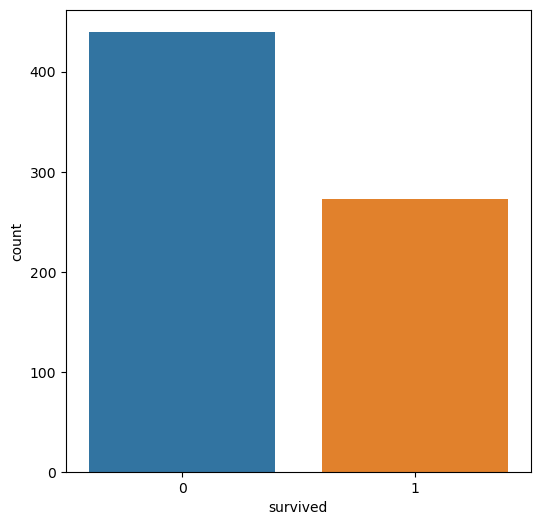

Columns with outlier percentage :-                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
  ColumnName  OutlierPercentage
0        age          21.037868
1      sibsp           4.908836
2       fare          13.183731
3      parch          24.964937


Analysis completed. No action taken.                                                    


survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,3,"Moore, Mr. Leonard Charles",male,None,0,0,A4. 54510,8.05,None,S
1,1,"Young, Miss. Marie Grice",female,36,0,0,PC 17760,135.6333,C32,C
0,3,"Williams, Mr. Howard Hugh ""Harry""",male,None,0,0,A/5 2466,8.05,None,S
0,2,"Berriman, Mr. William John",male,23,0,0,28425,13.0,None,S
0,2,"Fox, Mr. Stanley Hubert",male,36,0,0,229236,13.0,None,S
1,3,"Murphy, Miss. Katherine ""Kate""",female,None,1,0,367230,15.5,None,Q
0,3,"Allum, Mr. Owen George",male,18,0,0,2223,8.3,None,S
1,2,"Clarke, Mrs. Charles V (Ada Maria Winfield)",female,28,1,0,2003,26.0,None,S
0,3,"Henry, Miss. Delia",female,None,0,0,382649,7.75,None,Q
0,2,"Hocking, Mr. Richard George",male,23,2,1,29104,11.5,None,S


['ticket', 'name']


survived,pclass,sex,age,sibsp,parch,fare,cabin,embarked,id
0,2,male,36,0,0,13.0,None,S,12
0,3,female,None,0,0,7.75,None,Q,9
0,2,male,23,2,1,11.5,None,S,17
0,3,male,18,0,0,8.3,None,S,15
1,1,female,36,0,0,135.6333,C32,C,13
0,3,male,None,0,0,8.05,None,S,21
0,2,male,23,0,0,13.0,None,S,14
0,3,male,22,0,0,7.2292,None,C,22
1,3,female,14,1,0,11.2417,None,C,10
1,1,male,80,0,0,30.0,A23,S,18


Analysis Completed. Dataset does not contain any feature related to dates. No action needed.


['cabin']


survived,pclass,sex,age,sibsp,parch,fare,embarked,id
1,1,female,28,1,0,89.1042,C,136
1,1,male,49,1,0,56.9292,C,208
1,2,female,4,2,1,39.0,S,240
1,1,female,18,2,2,262.375,C,256
1,3,female,38,1,5,31.3875,S,272
1,1,female,33,1,0,90.0,Q,288
0,3,male,28,0,0,7.75,Q,50
0,3,male,30,0,0,8.05,S,82
0,3,male,29,0,0,7.875,S,90
0,3,male,19,0,0,10.1708,S,98


Proceeding with default option for handling remaining missing values.                    


embarked: 1


['embarked']


survived,pclass,sex,age,sibsp,parch,fare,embarked,id
0,3,male,29,0,0,7.875,S,90
0,2,male,25,1,2,41.5792,C,122
0,2,male,28,0,0,0.0,S,130
0,2,male,54,0,0,26.0,S,138
0,3,male,17,0,0,8.6625,S,154
0,2,male,46,0,0,26.0,S,170
1,1,female,32,0,0,76.2917,C,104
1,1,female,44,0,1,57.9792,C,128
1,1,female,28,1,0,89.1042,C,136
1,1,female,63,1,0,77.9583,S,176


Analysis completed. No imputation required.                                              


embarked,survived,parch,age,sex,sibsp,fare,id,pclass
Q,1,0,28,female,0,7.75,449,pclass_3
Q,1,0,28,female,0,7.75,342,pclass_3
Q,1,0,28,female,0,7.7333,654,pclass_3
Q,1,0,29,male,0,7.75,750,pclass_3
Q,1,0,28,female,2,23.25,276,pclass_3
Q,1,0,28,female,0,7.7875,332,pclass_3
C,1,0,28,female,1,89.1042,136,pclass_1
C,1,2,18,female,2,262.375,256,pclass_1
C,1,0,28,female,0,7.225,360,pclass_3
C,1,1,23,male,0,63.3583,424,pclass_1


No information provided for Variable-Width Transformation.                               
Skipping customized string manipulation.                                                 


sibsp,survived,parch,age,sex,embarked,fare,id,pclass
4,0,2,9,female,S,31.275,571,2
4,0,1,7,male,S,39.6875,255,2
4,0,1,16,male,S,39.6875,735,2
4,0,2,2,female,S,31.275,26,2
4,0,1,2,male,Q,29.125,49,2
4,0,1,4,male,Q,29.125,590,2
5,0,2,16,female,S,46.9,172,2
5,0,2,1,male,S,46.9,19,2
5,0,2,14,male,S,46.9,164,2
5,0,2,9,male,S,46.9,492,2


embarked,survived,parch,age,pclass,sex,sibsp,fare,id
0.36363636363636365,0,1,32,2,female,1,15.5,620
0.36363636363636365,1,0,28,2,female,1,15.5,634
0.36363636363636365,1,0,28,2,female,1,15.5,399
0.36363636363636365,1,0,28,2,female,2,23.25,276
0.36363636363636365,0,0,44,0,male,2,90.0,734
0.36363636363636365,0,1,8,2,male,4,29.125,421
0.33463796477495106,0,2,14,2,male,5,46.9,164
0.33463796477495106,0,2,11,2,male,5,46.9,384
0.33463796477495106,1,0,27,0,male,1,53.1,522
0.33463796477495106,1,0,22,0,female,1,66.6,227


['sex']


embarked,survived,parch,age,pclass,sex_0,sex_1,sibsp,fare,id
0.33463796477495106,1,0,36,2,1,0,1,17.4,186
0.33463796477495106,1,1,0,1,0,1,1,14.5,344
0.33463796477495106,1,1,37,0,0,1,1,52.5542,249
0.33463796477495106,1,5,38,2,1,0,1,31.3875,272
0.33463796477495106,0,0,44,1,0,1,1,26.0,437
0.33463796477495106,1,1,22,1,1,0,1,29.0,67
0.5579710144927537,1,0,15,2,1,0,0,7.225,362
0.5579710144927537,1,1,50,0,1,0,0,247.5208,466
0.5579710144927537,1,2,22,0,1,0,0,49.5,546
0.5579710144927537,1,0,28,0,1,0,0,110.8833,650


Skipping customized mathematical transformation.                                         


['Combination_1']


embarked,survived,parch,age,pclass,sex_0,sex_1,sibsp,fare,id,family_count
0.33463796477495106,1,1.0,37,0,0,1,1.0,52.5542,249,3.0
0.33463796477495106,0,0.0,44,1,0,1,1.0,26.0,437,2.0
0.33463796477495106,1,1.0,22,1,1,0,1.0,29.0,67,3.0
0.33463796477495106,0,2.0,26,2,0,1,1.0,20.575,490,4.0
0.33463796477495106,0,0.0,27,1,1,0,1.0,21.0,742,2.0
0.33463796477495106,0,0.0,40,2,1,0,1.0,9.475,301,2.0
0.36363636363636365,1,0.0,28,2,1,0,1.0,15.5,399,2.0
0.36363636363636365,0,0.0,44,0,0,1,2.0,90.0,734,3.0
0.36363636363636365,0,1.0,8,2,0,1,4.0,29.125,421,6.0
0.36363636363636365,0,1.0,2,2,0,1,4.0,29.125,49,6.0


No information provided for performing customized feature scaling. Proceeding with default option.
No information provided for performing customized imbalanced dataset sampling. AutoML will Proceed with default option.


No information provided for customized outlier processing. AutoML will proceed with default settings.


Columns with outlier percentage :-                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
     ColumnName  OutlierPercentage
0         parch          25.000000
1  family_count          10.393258
2      embarked          19.241573
3         sibsp           4.915730
4           age           7.724719
5          fare          13.061798


['age', 'sibsp']


embarked,survived,parch,age,pclass,sex_0,sex_1,sibsp,fare,id,family_count
0.33463796477495106,0,2.0,26,2,0,1,1.0,20.575,490,4.0
0.33463796477495106,0,0.0,40,2,1,0,1.0,9.475,301,2.0
0.33463796477495106,0,0.0,28,2,0,1,1.0,15.85,65,2.0
0.33463796477495106,1,1.0,45,0,1,0,1.0,164.8667,293,3.0
0.33463796477495106,1,0.0,42,0,0,1,1.0,52.5542,453,2.0
0.33463796477495106,1,0.0,28,0,1,0,1.0,52.0,487,2.0
0.36363636363636365,1,0.0,28,2,1,0,0.0,7.75,517,1.0
0.36363636363636365,1,0.0,19,2,1,0,0.0,7.8792,331,1.0
0.36363636363636365,1,0.0,28,2,1,0,0.0,7.7333,654,1.0
0.36363636363636365,1,0.0,29,2,0,1,0.0,7.75,750,1.0


['fare', 'embarked', 'parch', 'family_count']


embarked,survived,parch,age,pclass,sex_0,sex_1,sibsp,fare,id,family_count
0.33463796477495106,0,0.0,28,1,0,1,0.0,15.05,378,1.0
0.33463796477495106,0,0.0,28,2,0,1,0.0,7.8958,144,1.0
0.33463796477495106,0,0.0,37,0,0,1,0.0,29.7,192,2.0
0.33463796477495106,0,0.0,33,2,0,1,0.0,7.8958,200,1.0
0.33463796477495106,0,0.0,45,2,1,0,0.0,14.4542,432,2.0
0.33463796477495106,0,0.0,27,0,0,1,0.0,13.0,536,3.0
0.36363636363636365,1,0.0,28,2,1,0,0.0,7.7333,654,1.0
0.36363636363636365,1,0.0,30,1,1,0,0.0,12.35,380,1.0
0.36363636363636365,1,0.0,28,2,1,0,0.0,7.8792,548,1.0
0.36363636363636365,1,0.0,28,2,1,0,0.0,7.8292,700,1.0


['sibsp', 'sex_1', 'family_count', 'age', 'pclass', 'sex_0', 'embarked', 'fare']


['sibsp', 'family_count', 'age', 'pclass', 'embarked', 'fare']


survived,sex_0,sex_1,id,sibsp,family_count,age,pclass,embarked,fare
1,1,0,10,0.5,0.5,0.21568627450980393,1.0,0.0,0.1831516213961733
0,0,1,12,0.0,0.0,0.6470588235294118,0.5,0.0,0.21179813356967833
1,1,0,13,0.0,0.0,0.6470588235294118,0.0,0.0,0.21179813356967833
0,0,1,14,0.0,0.0,0.39215686274509803,0.5,0.0,0.21179813356967833
0,0,1,17,1.0,0.0,0.39215686274509803,0.5,0.0,0.1873598873885616
1,1,0,20,0.5,0.5,0.49019607843137253,1.0,1.0,0.25252854387153956
0,0,1,15,0.0,0.0,0.29411764705882354,1.0,0.0,0.13522496220217925
0,0,1,11,0.0,0.0,0.49019607843137253,1.0,0.0,0.13115192117199315
0,1,0,9,0.0,0.0,0.49019607843137253,1.0,1.0,0.12626427193576978
0,0,1,8,0.0,0.0,0.49019607843137253,1.0,1.0,0.12585696783275116


['sex_1', 'age', 'pclass', 'sex_0', 'embarked', 'sibsp', 'fare', 'family_count']


['r_age', 'r_pclass', 'r_embarked', 'r_sibsp', 'r_fare', 'r_family_count']


survived,r_sex_0,r_sex_1,id,r_age,r_pclass,r_embarked,r_sibsp,r_fare,r_family_count
1,1,0,10,0.21568627450980393,1.0,0.0,0.5,0.1831516213961733,0.5
0,0,1,12,0.6470588235294118,0.5,0.0,0.0,0.21179813356967833,0.0
1,1,0,13,0.6470588235294118,0.0,0.0,0.0,0.21179813356967833,0.0
0,0,1,14,0.39215686274509803,0.5,0.0,0.0,0.21179813356967833,0.0
0,0,1,17,0.39215686274509803,0.5,0.0,1.0,0.1873598873885616,0.0
1,1,0,20,0.49019607843137253,1.0,1.0,0.5,0.25252854387153956,0.5
0,0,1,15,0.29411764705882354,1.0,0.0,0.0,0.13522496220217925,0.0
0,0,1,11,0.49019607843137253,1.0,0.0,0.0,0.13115192117199315,0.0
0,1,0,9,0.49019607843137253,1.0,1.0,0.0,0.12626427193576978,0.0
0,0,1,8,0.49019607843137253,1.0,1.0,0.0,0.12585696783275116,0.0


['embarked', 'age', 'pclass', 'sibsp', 'fare', 'family_count']


sex_1,survived,parch,sex_0,id,embarked,age,pclass,sibsp,fare,family_count
1,0,0.0,0,378,0.0,0.49019607843137253,0.5,0.0,0.24519707001720456,0.0
1,0,0.0,0,144,0.0,0.49019607843137253,1.0,0.0,0.12863966946457434,0.0
1,0,0.0,0,192,0.0,0.6666666666666666,0.0,0.0,0.4838772743861113,0.5
1,0,0.0,0,200,0.0,0.5882352941176471,1.0,0.0,0.12863966946457434,0.0
0,0,0.0,1,432,0.0,0.8235294117647058,1.0,0.0,0.23549019863406498,0.5
1,0,0.0,0,536,0.0,0.47058823529411764,0.0,0.0,0.21179813356967833,1.0
0,1,0.0,1,654,1.0,0.49019607843137253,1.0,0.0,0.12599219279495336,0.0
0,1,0.0,1,380,1.0,0.5294117647058824,0.5,0.0,0.2012082268911944,0.0
0,1,0.0,1,548,1.0,0.49019607843137253,1.0,0.0,0.12836921954016997,0.0
0,1,0.0,1,700,1.0,0.49019607843137253,1.0,0.0,0.12755461133413273,0.0


['col_0', 'col_1', 'col_2', 'col_3', 'col_4', 'col_5']


                                                                                          
Skipping customized hyperparameter tuning


response_column : survived                                                                                                                            
name : xgboost
model_type : Classification
column_sampling : (1, 0.6)
min_impurity : (0.0, 0.1, 0.2)
lambda1 : (0.01, 0.1, 1, 10)
shrinkage_factor : (0.5, 0.1, 0.3)
max_depth : (5, 6, 8, 10)
min_node_size : (1, 2, 3)
iter_num : (10, 20, 30)
seed : 42
Total number of models for xgboost : 2592
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

response_column : survived
name : decision_forest
tree_type : Classification
min_impurity : (0.0, 0.1, 0.2)
max_depth : (5, 6, 8, 10)
min_node_size : (1, 2, 3)
num_trees : (-1, 20, 30)
seed : 42
Total number of models for decision_forest : 108
--------------------------------------------------------------------------------------------------------------

,RANK,MODEL_ID,FEATURE_SELECTION,ACCURACY,MICRO-PRECISION,MICRO-RECALL,MICRO-F1,MACRO-PRECISION,MACRO-RECALL,MACRO-F1,WEIGHTED-PRECISION,WEIGHTED-RECALL,WEIGHTED-F1
0,1,XGBOOST_0,lasso,0.769841,0.769841,0.769841,0.769841,0.760714,0.770872,0.763265,0.778968,0.769841,0.772033
1,2,XGBOOST_1,rfe,0.769841,0.769841,0.769841,0.769841,0.759259,0.767161,0.761908,0.775720,0.769841,0.771566
2,3,DECISIONFOREST_2,pca,0.753968,0.753968,0.753968,0.753968,0.746221,0.724490,0.730751,0.750937,0.753968,0.748321
3,4,DECISIONFOREST_0,lasso,0.746032,0.746032,0.746032,0.746032,0.733333,0.725417,0.728521,0.743210,0.746032,0.743843
4,5,DECISIONFOREST_1,rfe,0.746032,0.746032,0.746032,0.746032,0.733333,0.725417,0.728521,0.743210,0.746032,0.743843


In [18]:
# Fitting train data
aml.fit(titanic_train, titanic_train.survived)

## <b><span style='color:#F1A424'>| 3.</span> Leaderboard : </b>

In [19]:
# Fetching Leaderboard
aml.leaderboard()

,RANK,MODEL_ID,FEATURE_SELECTION,ACCURACY,MICRO-PRECISION,MICRO-RECALL,MICRO-F1,MACRO-PRECISION,MACRO-RECALL,MACRO-F1,WEIGHTED-PRECISION,WEIGHTED-RECALL,WEIGHTED-F1
0,1,XGBOOST_0,lasso,0.769841,0.769841,0.769841,0.769841,0.760714,0.770872,0.763265,0.778968,0.769841,0.772033
1,2,XGBOOST_1,rfe,0.769841,0.769841,0.769841,0.769841,0.759259,0.767161,0.761908,0.775720,0.769841,0.771566
2,3,DECISIONFOREST_2,pca,0.753968,0.753968,0.753968,0.753968,0.746221,0.724490,0.730751,0.750937,0.753968,0.748321
3,4,DECISIONFOREST_0,lasso,0.746032,0.746032,0.746032,0.746032,0.733333,0.725417,0.728521,0.743210,0.746032,0.743843
4,5,DECISIONFOREST_1,rfe,0.746032,0.746032,0.746032,0.746032,0.733333,0.725417,0.728521,0.743210,0.746032,0.743843


## <b><span style='color:#F1A424'>| 4.</span> Best Performing Model : </b>

In [20]:
# Fetching best performing model for dataset
aml.leader()

,RANK,MODEL_ID,FEATURE_SELECTION,ACCURACY,MICRO-PRECISION,MICRO-RECALL,MICRO-F1,MACRO-PRECISION,MACRO-RECALL,MACRO-F1,WEIGHTED-PRECISION,WEIGHTED-RECALL,WEIGHTED-F1
0,1,XGBOOST_0,lasso,0.769841,0.769841,0.769841,0.769841,0.760714,0.770872,0.763265,0.778968,0.769841,0.772033


## <b><span style='color:#F1A424'>| 5.</span> Get Hyperparameter for Trained Model : </b>

In [21]:
aml.model_hyperparameters(rank=1)

{'response_column': 'survived',
 'name': 'xgboost',
 'model_type': 'Classification',
 'column_sampling': 1,
 'min_impurity': 0.1,
 'lambda1': 0.01,
 'shrinkage_factor': 0.5,
 'max_depth': 8,
 'min_node_size': 3,
 'iter_num': 10,
 'seed': 42,
 'persist': False,
 'output_prob': True,
 'output_responses': ['1', '0'],
 'max_models': 1}

In [22]:
aml.model_hyperparameters(rank=4)

{'response_column': 'survived',
 'name': 'decision_forest',
 'tree_type': 'Classification',
 'min_impurity': 0.0,
 'max_depth': 10,
 'min_node_size': 2,
 'num_trees': 20,
 'seed': 42,
 'persist': False,
 'output_prob': True,
 'output_responses': ['1', '0'],
 'max_models': 1}

## <b><span style='color:#F1A424'>| 6.</span> Generate Prediction and Performance Metrics : </b>

In [23]:
# Generating prediction on test data
prediction = aml.predict(titanic_test)

Data Transformation started ...


passenger,survived,pclass,sex,age,sibsp,parch,fare,cabin,embarked,id
591,0,3,male,35,0,0,7.125,None,S,11
486,0,3,female,None,3,1,25.4667,None,S,8
381,1,1,female,42,0,0,227.525,None,C,16
80,1,3,female,30,0,0,12.475,None,S,12
570,1,3,male,32,0,0,7.8542,None,S,15
162,1,2,female,40,0,0,15.75,None,S,23
873,0,1,male,33,0,0,5.0,B51 B53 B55,S,9
301,1,3,female,None,0,0,7.75,None,Q,17
751,1,2,female,4,1,1,23.0,None,S,10
543,0,3,female,11,4,2,31.275,None,S,18


embarked,cabin,parch,age,passenger,sex,pclass,sibsp,fare,id,survived
S,B51 B53 B55,0,33,873,male,1,0,5.0,9,0
C,None,0,11,732,male,3,0,18.7875,13,0
S,None,0,25,667,male,2,0,13.0,21,0
S,None,0,32,570,male,3,0,7.8542,15,1
S,None,0,30,80,female,3,0,12.475,12,1
S,None,0,21,38,male,3,0,8.05,20,0
S,None,0,35,591,male,3,0,7.125,11,0
S,None,0,31,19,female,3,1,18.0,19,0
S,None,1,4,751,female,2,1,23.0,10,1
S,None,2,11,543,female,3,4,31.275,18,0


embarked,parch,age,passenger,sex,pclass,sibsp,fare,id,survived
S,0,33,873,male,1,0,5.0,9,0
S,0,30,80,female,3,0,12.475,12,1
S,0,21,38,male,3,0,8.05,20,0
S,0,35,591,male,3,0,7.125,11,0
C,0,11,732,male,3,0,18.7875,13,0
S,0,25,667,male,2,0,13.0,21,0
S,0,32,570,male,3,0,7.8542,15,1
S,0,40,162,female,2,0,15.75,23,1
S,2,None,181,female,3,8,69.55,14,0
C,0,None,257,female,1,0,79.2,22,1


embarked,parch,age,passenger,sex,pclass,sibsp,fare,id,survived
S,0,35,591,male,3,0,7.125,11,0
S,2,28,181,female,3,8,69.55,14,0
C,0,28,257,female,1,0,79.2,22,1
S,0,32,570,male,3,0,7.8542,15,1
S,0,33,873,male,1,0,5.0,9,0
Q,0,28,301,female,3,0,7.75,17,1
C,0,11,732,male,3,0,18.7875,13,0
S,0,25,667,male,2,0,13.0,21,0
S,0,30,80,female,3,0,12.475,12,1
S,0,21,38,male,3,0,8.05,20,0


embarked,parch,age,passenger,sex,pclass,sibsp,fare,id,survived
S,0,35,591,male,3,0,7.125,11,0
S,0,33,873,male,1,0,5.0,9,0
Q,0,28,301,female,3,0,7.75,17,1
C,0,11,732,male,3,0,18.7875,13,0
S,2,28,181,female,3,8,69.55,14,0
C,0,28,257,female,1,0,79.2,22,1
S,0,30,80,female,3,0,12.475,12,1
S,0,21,38,male,3,0,8.05,20,0
S,1,4,751,female,2,1,23.0,10,1
S,2,11,543,female,3,4,31.275,18,0


embarked,parch,age,passenger,sex,pclass,sibsp,fare,id,survived
S,0,33,873,male,1,0,5.0,9,0
S,1,28,486,female,3,3,25.4667,8,0
C,0,42,381,female,1,0,227.525,16,1
S,0,32,570,male,3,0,7.8542,15,1
S,0,30,80,female,3,0,12.475,12,1
S,0,21,38,male,3,0,8.05,20,0
S,0,35,591,male,3,0,7.125,11,0
S,0,31,19,female,3,1,18.0,19,0
C,0,11,732,male,3,0,18.7875,13,0
S,0,25,667,male,2,0,13.0,21,0


sibsp,survived,parch,age,passenger,sex,embarked,fare,id,pclass
3,0,2,19,28,male,S,263.0,46,pclass_1
3,0,1,28,230,female,S,25.4667,50,pclass_3
3,0,1,2,8,male,S,21.075,136,pclass_3
3,0,1,28,486,female,S,25.4667,8,pclass_3
1,1,0,17,308,female,C,108.9,64,pclass_1
1,1,0,24,317,female,S,26.0,155,pclass_2
1,1,1,4,751,female,S,23.0,10,pclass_2
1,1,0,28,432,female,S,16.1,83,pclass_3
1,0,0,31,19,female,S,18.0,19,pclass_3
1,1,1,0,832,male,S,18.75,131,pclass_2


embarked,sibsp,survived,parch,age,passenger,sex,pclass,fare,id
0.36363636363636365,0,1,0,15,23,female,2,8.0292,191
0.36363636363636365,0,1,0,28,574,female,2,7.75,153
0.36363636363636365,0,0,0,32,891,male,2,7.75,98
0.36363636363636365,0,1,0,16,209,female,2,7.75,59
0.36363636363636365,0,0,0,28,826,male,2,6.95,164
0.36363636363636365,0,0,0,18,655,female,2,6.75,89
0.33463796477495106,0,0,0,20,841,male,2,7.925,171
0.33463796477495106,0,1,0,44,415,male,2,7.925,42
0.33463796477495106,0,0,0,16,575,male,2,8.05,58
0.33463796477495106,0,1,0,28,508,male,0,26.55,74


embarked,sibsp,survived,parch,age,passenger,sex_0,sex_1,pclass,fare,id
0.33463796477495106,0,0,0,26,620,0,1,1,10.5,130
0.33463796477495106,0,0,0,24,865,0,1,1,13.0,40
0.33463796477495106,0,0,0,41,762,0,1,2,7.125,48
0.33463796477495106,0,0,0,35,5,0,1,2,8.05,56
0.33463796477495106,0,0,0,21,73,0,1,1,73.5,96
0.33463796477495106,0,1,0,30,521,1,0,0,93.5,104
0.36363636363636365,0,1,0,15,23,1,0,2,8.0292,191
0.36363636363636365,0,1,0,28,574,1,0,2,7.75,153
0.36363636363636365,0,0,0,32,891,0,1,2,7.75,98
0.36363636363636365,0,1,0,16,209,1,0,2,7.75,59


embarked,sibsp,survived,parch,age,passenger,sex_0,sex_1,pclass,fare,id,family_count
0.33463796477495106,0.0,0,0.0,41,762,0,1,2,7.125,48,1.0
0.33463796477495106,0.0,0,0.0,21,73,0,1,1,73.5,96,1.0
0.33463796477495106,0.0,1,0.0,30,521,1,0,0,93.5,104,1.0
0.33463796477495106,0.0,0,0.0,24,235,0,1,1,10.5,112,1.0
0.33463796477495106,0.0,0,0.0,45,130,0,1,2,6.975,144,1.0
0.33463796477495106,0.0,0,0.0,28,170,0,1,2,56.4958,152,1.0
0.5579710144927537,0.0,1,0.0,30,843,1,0,0,31.0,163,1.0
0.5579710144927537,0.0,0,0.0,28,27,0,1,2,7.225,138,1.0
0.5579710144927537,0.0,1,0.0,42,381,1,0,0,227.525,16,1.0
0.5579710144927537,0.0,1,1.0,36,680,0,1,0,512.3292,41,2.0


embarked,sibsp,survived,parch,age,sex_0,sex_1,pclass,fare,id,family_count
0.33463796477495106,0.0,0,0.0,41,0,1,2,7.125,48,1.0
0.33463796477495106,0.0,0,0.0,21,0,1,1,73.5,96,1.0
0.33463796477495106,0.0,1,0.0,30,1,0,0,93.5,104,1.0
0.33463796477495106,0.0,0,0.0,24,0,1,1,10.5,112,1.0
0.33463796477495106,0.0,0,0.0,45,0,1,2,6.975,144,1.0
0.33463796477495106,0.0,0,0.0,28,0,1,2,56.4958,152,1.0
0.36363636363636365,0.0,0,0.0,32,0,1,2,7.75,98,1.0
0.36363636363636365,0.0,0,0.0,28,0,1,2,6.95,164,1.0
0.36363636363636365,0.0,0,0.0,18,1,0,2,6.75,89,1.0
0.36363636363636365,0.0,1,0.0,28,1,0,2,7.75,114,1.0


id,sibsp,sex_1,family_count,age,pclass,sex_0,embarked,fare,survived
69,1.0,0,3.0,28,2,1,0.558,22.3583,1
76,1.0,0,2.0,28,2,1,0.558,14.4583,0
53,1.0,0,2.0,54,0,1,0.558,78.2667,1
22,0.0,0,1.0,28,0,1,0.558,79.2,1
101,1.0,0,3.0,9,2,1,0.558,15.2458,0
147,0.0,0,1.0,44,0,1,0.558,27.7208,1
48,0.0,1,1.0,41,2,0,0.3346,7.125,0
96,0.0,1,1.0,21,1,0,0.3346,73.5,0
112,0.0,1,1.0,24,1,0,0.3346,10.5,0
128,0.0,1,1.0,51,1,0,0.3346,12.525,0


survived,sex_0,sex_1,id,sibsp,family_count,age,pclass,embarked,fare
0,0,1,112,0.0,0.0,0.4117647058823529,0.5,0.0,0.1710677232678171
0,0,1,152,0.0,0.0,0.49019607843137253,1.0,0.0,0.9204388457327565
0,0,1,176,0.0,0.0,0.29411764705882354,0.5,0.0,0.1873598873885616
1,0,1,33,0.0,0.0,0.49019607843137253,1.0,0.0,0.9204388457327565
0,0,1,81,0.0,0.0,0.803921568627451,1.0,0.0,0.13115192117199315
0,0,1,97,0.0,0.0,0.9411764705882353,1.0,0.0,0.12626427193576978
0,1,0,30,0.0,0.5,0.29411764705882354,1.0,7.703448275862078,0.23549019863406498
1,1,0,100,0.5,0.5,1.1176470588235294,0.0,7.703448275862078,1.2259853500860227
1,1,0,69,0.5,1.0,0.49019607843137253,1.0,7.703448275862078,0.3642650930608415
1,1,0,64,0.5,0.5,0.27450980392156865,0.0,7.703448275862078,1.7742166727490747


id,sex_1,age,pclass,sex_0,embarked,sibsp,fare,family_count,survived
112,1,24,1,0,0.3346,0.0,10.5,1.0,0
152,1,28,2,0,0.3346,0.0,56.4958,1.0,0
176,1,18,1,0,0.3346,0.0,11.5,1.0,0
33,1,28,2,0,0.3346,0.0,56.4958,1.0,1
81,1,44,2,0,0.3346,0.0,8.05,1.0,0
97,1,51,2,0,0.3346,0.0,7.75,1.0,0
30,0,18,2,1,0.558,0.0,14.4542,2.0,0
100,0,60,0,1,0.558,1.0,75.25,2.0,1
69,0,28,2,1,0.558,1.0,22.3583,3.0,1
64,0,17,0,1,0.558,1.0,108.9,2.0,1


survived,r_sex_0,r_sex_1,id,r_age,r_pclass,r_embarked,r_sibsp,r_fare,r_family_count
0,0,1,112,0.4117647058823529,0.5,0.0,0.0,0.1710677232678171,0.0
0,0,1,152,0.49019607843137253,1.0,0.0,0.0,0.9204388457327565,0.0
0,0,1,176,0.29411764705882354,0.5,0.0,0.0,0.1873598873885616,0.0
1,0,1,33,0.49019607843137253,1.0,0.0,0.0,0.9204388457327565,0.0
0,0,1,81,0.803921568627451,1.0,0.0,0.0,0.13115192117199315,0.0
0,0,1,97,0.9411764705882353,1.0,0.0,0.0,0.12626427193576978,0.0
0,1,0,30,0.29411764705882354,1.0,7.703448275862078,0.0,0.23549019863406498,0.5
1,1,0,100,1.1176470588235294,0.0,7.703448275862078,0.5,1.2259853500860227,0.5
1,1,0,69,0.49019607843137253,1.0,7.703448275862078,0.5,0.3642650930608415,1.0
1,1,0,64,0.27450980392156865,0.0,7.703448275862078,0.5,1.7742166727490747,0.5


sex_1,survived,parch,sex_0,id,embarked,age,pclass,sibsp,fare,family_count
1,0,0.0,0,112,-0.001309202453986794,0.4117647058823529,0.5,0.0,0.1710677232678171,0.0
1,0,0.0,0,152,-0.001309202453986794,0.49019607843137253,1.0,0.0,0.9204388457327565,0.0
1,0,0.0,0,176,-0.001309202453986794,0.29411764705882354,0.5,0.0,0.1873598873885616,0.0
1,1,0.0,0,33,-0.001309202453986794,0.49019607843137253,1.0,0.0,0.9204388457327565,0.0
1,0,0.0,0,81,-0.001309202453986794,0.803921568627451,1.0,0.0,0.13115192117199315,0.0
1,0,0.0,0,97,-0.001309202453986794,0.9411764705882353,1.0,0.0,0.12626427193576978,0.0
0,0,1.0,1,30,7.702564417177909,0.29411764705882354,1.0,0.0,0.23549019863406498,0.5
0,1,0.0,1,100,7.702564417177909,1.1176470588235294,0.0,0.5,1.2259853500860227,0.5
0,1,1.0,1,69,7.702564417177909,0.49019607843137253,1.0,0.5,0.3642650930608415,1.0
0,1,0.0,1,64,7.702564417177909,0.27450980392156865,0.0,0.5,1.7742166727490747,0.5


C:\ProgramData\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


,id,col_0,col_1,col_2,col_3,col_4,col_5,survived
0,48,-0.604079,-0.251408,-0.082146,-0.116307,-0.141388,-0.241917,0
1,30,1.083819,-2.515037,0.920687,7.062517,0.789084,0.377344,0
2,96,-0.439311,0.376303,-0.260180,0.024478,-0.076691,0.327340,0
3,100,1.388431,-1.238005,0.658307,7.497925,-0.008191,0.191678,1
4,112,-0.508756,0.115662,-0.259576,-0.036426,0.114863,0.093730,0
5,69,1.222904,-2.182757,1.518028,7.114807,0.549365,0.286522,1
6,128,-0.505860,0.195651,-0.310560,0.035997,-0.172383,-0.335267,0
7,64,1.424510,-1.208196,0.735848,7.422800,0.318941,0.983343,1
8,152,-0.549918,-0.075297,-0.062591,-0.096272,-0.181032,0.112703,0
9,76,1.136537,-2.376952,1.142662,7.107592,0.354982,0.424665,0


Data Transformation completed.⫿⫿⫿⫿⫿⫿⫿⫿⫿⫿⫿⫿⫿⫿⫿⫿⫿⫿⫿⫿⫿⫿⫿⫿⫿⫿⫿⫿⫿⫿⫿⫿⫿⫿⫿⫿⫿⫿⫿⫿⫿⫿｜ 100% - 15/15            

Following model is being picked for evaluation:
Model ID : XGBOOST_0 
Feature Selection Method : lasso

Prediction : 
    id  Prediction  survived    prob_0    prob_1
0   69           1         1  0.212129  0.787871
1   76           1         0  0.212129  0.787871
2   53           1         1  0.014311  0.985689
3   22           1         1  0.014311  0.985689
4  101           1         0  0.212129  0.787871
5  147           1         1  0.124797  0.875203
6   48           0         0  0.913048  0.086952
7   96           1         0  0.308215  0.691785
8  112           0         0  0.764506  0.235494
9  128           0         0  0.813978  0.186022

ROC-AUC : 


AUC,GINI
0.8124662709120346,0.6249325418240692


threshold_value,tpr,fpr
0.04081632653061224,1.0,1.0
0.08163265306122448,1.0,1.0
0.1020408163265306,0.9852941176470589,0.9174311926605505
0.12244897959183673,0.9852941176470589,0.908256880733945
0.16326530612244897,0.8823529411764706,0.5688073394495413
0.18367346938775508,0.8823529411764706,0.5688073394495413
0.14285714285714285,0.9852941176470589,0.908256880733945
0.061224489795918366,1.0,1.0
0.02040816326530612,1.0,1.0
0.0,1.0,1.0



Confusion Matrix : 


array([[76, 33],
       [11, 57]], dtype=int64)

In [24]:
# Printing prediction
prediction.head()

id,Prediction,survived,prob_0,prob_1
10,1,1,0.06468306615212427,0.9353169338478757
12,1,1,0.21212896501799006,0.7878710349820099
13,1,0,0.41290357079993467,0.5870964292000653
14,1,0,0.04773688538151222,0.9522631146184878
16,1,1,0.014311090515482183,0.9856889094845178
17,1,1,0.26754463336397494,0.7324553666360251
15,0,1,0.8516859663524107,0.14831403364758936
11,0,0,0.8516859663524107,0.14831403364758936
9,1,0,0.4883748454429272,0.5116251545570728
8,1,0,0.21212896501799006,0.7878710349820099


In [25]:
# Fetching performance metrics on test data
performance_metrics = aml.evaluate(titanic_test)


Skipping data transformation as data is already transformed.

Following model is being picked for evaluation:
Model ID : XGBOOST_0 
Feature Selection Method : lasso

Performance Metrics : 
       Prediction  Mapping  CLASS_1  CLASS_2  Precision    Recall        F1  Support
SeqNum                                                                              
0               0  CLASS_1       76       11   0.873563  0.697248  0.775510      109
1               1  CLASS_2       33       57   0.633333  0.838235  0.721519       68
--------------------------------------------------------------------------------
   SeqNum              Metric  MetricValue
0       3        Micro-Recall     0.751412
1       5     Macro-Precision     0.753448
2       6        Macro-Recall     0.767742
3       7            Macro-F1     0.748515
4       9     Weighted-Recall     0.751412
5      10         Weighted-F1     0.754768
6       8  Weighted-Precision     0.781272
7       4            Micro-F1     0.751412
8 

In [26]:
performance_metrics

SeqNum,Prediction,Mapping,CLASS_1,CLASS_2,Precision,Recall,F1,Support
0,0,CLASS_1,76,11,0.8735632183908046,0.6972477064220184,0.7755102040816326,109
1,1,CLASS_2,33,57,0.6333333333333333,0.8382352941176471,0.7215189873417721,68


In [27]:
remove_context()

True